In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

train=pd.read_csv('data/train.csv').drop('id',axis=1)
test=pd.read_csv('data/test.csv').drop('id',axis=1)
submission=pd.read_csv('data/submission.csv',index_col=0)

train_cpy=train.copy()
test_cpy=test.copy()
submission_cpy=submission.copy()

In [70]:
train_cpy=train_cpy.drop(['hour_bef_pm2.5','hour_bef_pm10',],axis=1)

In [71]:
median=train_cpy.median()
train_fil=train_cpy.fillna(median,inplace=False)
train_fil.isnull().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
count                     0
dtype: int64

In [72]:
train_set,valid_set=\
    train_test_split(
        train_fil,
        test_size=.2,
        shuffle=True,
        random_state=42)

In [73]:
train_set.groupby('hour').count()

,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,count
hour,,,,,,,
0,53,53,53,53,53,53,53
1,47,47,47,47,47,47,47
2,50,50,50,50,50,50,50
3,42,42,42,42,42,42,42
4,49,49,49,49,49,49,49
5,46,46,46,46,46,46,46
6,50,50,50,50,50,50,50
7,50,50,50,50,50,50,50
8,50,50,50,50,50,50,50


In [74]:
X_train=train_set.drop(['count'],axis=1)
y_train=train_set['count']
X_valid=valid_set.drop(['count'],axis=1)
y_valid=valid_set['count']

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [76]:
def get_model_score(model,X_train,y_train,X_val,y_val):
    pred_tr_arr=cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
    pred_val_arr=cross_val_score(model,X_val,y_val,scoring='neg_mean_squared_error',cv=5)
    print('train set RMSE : {}'.format(np.round(np.sqrt(np.mean(-1*pred_tr_arr)),2)))
    print('valid set RMSE : {}'.format(np.round(np.sqrt(np.mean(-1*pred_val_arr)),2)))

In [57]:
rf=RandomForestRegressor()

In [58]:
get_model_score(rf,X_train,y_train,X_valid,y_valid)

train set RMSE : 40.31
valid set RMSE : 45.47


In [96]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[int(x) for x in np.linspace(start=100,stop=4000,num=10)]
max_depth=[int(x) for x in np.linspace(start=1,stop=100,num=10)]
max_depth.append(None)
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]

random_grid={
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
}

In [97]:
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 12, 23, 34, 45, 56, 67,
                                                      78, 89, 100, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 533, 966, 1400,
                                                         1833, 2266, 2700, 3133,
                                                         3566, 4000]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [98]:
rf_random.best_params_

{'n_estimators': 3566,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 100,
 'bootstrap': True}

In [99]:
rf_best=RandomForestRegressor(
    n_estimators=3566,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=100,
    bootstrap=True)

get_model_score(rf_best,X_train,y_train,X_valid,y_valid)

train set RMSE : 40.19
valid set RMSE : 45.29


In [91]:
test_cpy=test_cpy.drop(['hour_bef_pm2.5','hour_bef_pm10',],axis=1)

KeyError: "['hour_bef_pm2.5', 'hour_bef_pm10'] not found in axis"

In [ ]:
median=train_cpy.median()
test_fil=test_cpy.fillna(median,inplace=False)
test_fil.isnull().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
dtype: int64

In [92]:
X_train_full=train_fil.drop('count',axis=1)
y_train_full=train_fil['count']

In [100]:
rf_best.fit(X_train_full,y_train_full)

RandomForestRegressor(max_depth=100, n_estimators=3566)

In [101]:
pred=rf_best.predict(test_fil)
submission_cpy['count']=pred
submission_cpy

,count
id,
0,91.091139
1,224.723219
2,76.598710
4,28.922883
5,53.187044
...,...
2148,58.074874
2149,71.148345
2165,116.685081


In [102]:
submission_cpy.to_csv('jan17_4000.csv')

In [27]:
ftr_importances_values=rf_best.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train_full.columns)
sorted_ftr_imp=ftr_importances.sort_values(ascending=False)

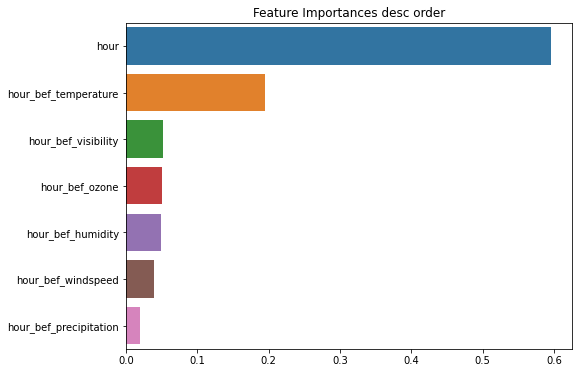

In [28]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances desc order')
sns.barplot(x=sorted_ftr_imp,y=sorted_ftr_imp.index)
plt.show()